# SI 618 WN Project Part I

## Project Title:
> Provide a descriptive working title for your project.

**Game Sales, Popularity, and Achievements: A Comparative Analysis Across Platforms**

## Team Members
> List each team member and include their uniqname

* Yufeng Song (yfsong)
* Ziqi Wang (Venchy)
* Muyu Lin (linmuyu)

## Overview
> Give a high level description of your project

Our project explores key trends in the gaming industry by analyzing data on game sales, player achievements, and platform preferences. We aim to understand how the same game performs across different platforms, how purchasing preferences vary across countries, and how game popularity evolves over time. Additionally, we will investigate the relationship between supported languages and sales, as well as the impact of pricing on game popularity across multiple platforms. By analyzing these factors, we hope to uncover insights into player behavior, market trends, and factors influencing game success.

## Motivation
> Explain why you chose this particular topic for your project.	Include the three "real-world" questions that you generated about the data, and be sure to explain what you hope to learn by answering them.

We chose this topic because gaming is a massive industry with a highly diverse audience, and understanding player preferences and market trends can provide valuable insights for developers, publishers, and gaming communities. Our project aims to answer the following real-world questions:

1. **How do game genres, game pricing, and in-game achievements differ across platforms for the same game?**

  - By analyzing achievement data, we aim to understand whether players engage with a game differently depending on the platform they use. This could reveal differences in play styles, game difficulty adjustments, or platform-specific engagement trends.

2. **How do game purchase preferences vary by country?**

  - We seek to determine whether purchasing behaviors differ based on regional preferences. Understanding this can help developers tailor their marketing strategies and optimize game pricing for different audiences.

3. **How has the popularity of different game types changed over time (`release_date`)?**

  - By tracking shifts in game genre popularity over time, we hope to uncover trends that indicate the rise and fall of specific genres. This insight could be useful for predicting future market demands and guiding game development strategies.


By answering these questions, we hope to gain a deeper understanding of the gaming landscape, helping stakeholders make data-driven decisions about game development, pricing, and distribution strategies.

## Data Sources
> List the two (or more) sources of data that you'll be using.  Provide URLs where appropriate.	**Explain how the two (or more) datasets complement each other.**

1. https://www.kaggle.com/datasets/artyomkruglov/gaming-profiles-2025-steam-playstation-xbox

2. https://github.com/Smipe-a/gamestatshub

- This Gaming Profiles Data from Kaggle include **game** and **player** data from three different **platforms**, PlayStation, Steam, and Xbox.
- For each platform, the **player** and **game** data is complemented by **achievement** data. The relationships between players, games, and achievements are one-to-many: each player can play multiple games, and each game can have multiple achievements.
- Data from the three platforms can be combined based on **game titles** to analyze shared games across platforms.

## Data Description
> List the variables of interest, the size of the data sets, missing values, etc.

### Common Datasets Across 3 Platforms & Variables of Interest:

#### Player Metadata
- **players.csv**: platform-specific `playerid` and `country` (Xbox data lacks country column)
- **purchased_games.csv** lists players' purchased games, with:
    - `playerid`
    - `libarary`: a list of games the player bought.
- **history.csv**: when the player unlocked the achievement.
    - `playerid`
    - `achievementid`
    - `date_acquired`

#### Game Metadata
- **games.csv**: game details such as `genres`, `developers`, `publishers`, `supported_language`, and `release_date`.
- **achievements.csv** maps achievements to their respective game, with:
    - `achievementid` combines the uniqe game id on the platform and the achievement id within the game
    - `gameid`
    - `title`
    - `description`
- **prices.csv**: games' price in various currencies, with `date_acquired` indicating the date when the price was recorded.

## Data Manipulation
> Mostly code in this section.  This is where you merge your data sets, as well as create new columns (if appropriate)

#### Merged Datasets Explained - Flattened Table For Raw Analysis
- Platform-Specific Datasets:
    - Player-Info Dataset: merged on `playerid`
    - Game-Info Dataset: merged on `gameid`
- Cross-Platform Game Dataset: merged on game `title` to combine shared game data from all three platforms.

**Notes**: 
- In all the merged datasets, there are duplicated gameid/playerid after merge due to the one-to-many relationship between players, games, and achievements. 
- In the corss-platform game table, there are duplicated game titles across platforms.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## PS

In [3]:
import os

PS_DATA_FOLDER = "data/ps"

dfs = {}

for root, dirs, files in os.walk(PS_DATA_FOLDER):
    for file in files:
        if file.endswith(".csv"):
            file_path = os.path.join(root, file)
            df_name = f"{os.path.basename(root)}_{file.replace('.csv', '')}".replace('.csv', '')  # Clean name
            dfs[df_name] = pd.read_csv(file_path)

for name, df in dfs.items():
    print(f"{name} - shape: {df.shape}")

ps_purchased_games - shape: (46582, 2)
ps_history - shape: (19510083, 3)
ps_prices - shape: (62816, 7)
ps_players - shape: (356600, 3)
ps_games - shape: (23151, 8)
ps_achievements - shape: (846563, 5)


In [4]:
ps_achievements = dfs['ps_achievements']
ps_games = dfs['ps_games']
ps_history = dfs['ps_history']
ps_players = dfs['ps_players']
ps_prices = dfs['ps_prices']
ps_purchased_games = dfs['ps_purchased_games']

# check duplicates
print(ps_games.duplicated(subset=["gameid"]).sum())
print(ps_prices.duplicated(subset=["gameid"]).sum())
print(ps_achievements.duplicated(subset=["achievementid"]).sum())
print(ps_players.duplicated(subset=["playerid"]).sum())
print(ps_purchased_games.duplicated(subset=["playerid"]).sum())

0
32095
0
0
0


In [5]:
ps_prices['gameid'].value_counts()

gameid
726666    3
723091    3
727730    3
727729    3
728792    3
         ..
421567    2
421164    2
421153    2
421368    2
423969    2
Name: count, Length: 30721, dtype: int64

In [6]:
ps_prices[ps_prices['gameid'] == 726666]

,gameid,usd,eur,gbp,jpy,rub,date_acquired
20167,726666,6.99,6.99,5.79,1100.0,NaN,2025-02-22
50835,726666,6.99,6.99,5.79,1100.0,NaN,2025-02-25
52307,726666,6.99,6.99,5.79,1100.0,NaN,2025-02-24


In [7]:
# for each gameid, keep only the most recent price entry
ps_prices = ps_prices.sort_values("date_acquired").drop_duplicates(subset=["gameid"], keep="last")
print(ps_prices.duplicated(subset=["gameid"]).sum())

0


### Player focus

In [104]:
ps_player_info = ps_players.merge(ps_history, on="playerid", how="left")

In [105]:
ps_player_info = ps_player_info.merge(ps_achievements, on="achievementid", how="left")

In [106]:
ps_player_info = ps_player_info.merge(ps_purchased_games, on="playerid", how="left")

In [107]:
ps_player_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19861683 entries, 0 to 19861682
Data columns (total 10 columns):
 #   Column         Dtype  
---  ------         -----  
 0   playerid       int64  
 1   nickname       object 
 2   country        object 
 3   achievementid  object 
 4   date_acquired  object 
 5   gameid         float64
 6   title          object 
 7   description    object 
 8   rarity         object 
 9   library        object 
dtypes: float64(1), int64(1), object(8)
memory usage: 1.5+ GB


In [108]:
ps_player_info.sample(5)

,playerid,nickname,country,achievementid,date_acquired,gameid,title,description,rarity,library
16469301,1686630,MoonlessBlaze,United States,10455_120586,2015-12-31 18:44:41,10455.0,Guardian of Grannet,Awarded for defeating the living statue and sa...,Bronze,"[437991, 717169, 637784, 711591, 701839, 52034..."
19324895,191243,NinjaXdesu,Sweden,5760_72741,2015-03-14 23:25:23,5760.0,Trippin,Trip up Lil in 5 rooms,Bronze,"[9936, 11611, 6543, 10954, 8600, 7899, 8906, 6..."
1587793,328637,grattemoi,Canada,67_1744,2012-03-08 03:39:25,67.0,Merchant,Collect 8 schematics,Bronze,"[702561, 430193, 618458, 550305, 646222, 55368..."
1373491,385147,patrickogorman19,Australia,438658_3968913,2022-03-02 10:44:16,438658.0,Map 58,Map 58 completed,Bronze,"[631356, 494531, 690610, 577437, 359520, 57331..."
17932424,1711950,Post-indie1989,Mexico,3310_46107,2014-03-08 05:43:47,3310.0,"You Snooze, You Lose",Sneak up on The End and hold him up,Silver,"[670209, 567443, 464111, 560737, 554077, 41778..."


### Game focus
date_acquired column is dropped as it indicates the timestamp when the price info was extracted from multiple databases and do not add helpful insights to our analysis.

In [109]:
ps_game_info = ps_games.merge(ps_achievements.rename(columns={'title': 'achievement_title'}), on="gameid", how="left")

In [14]:
ps_game_info = ps_game_info.merge(ps_prices, on="gameid", how="left")

In [15]:
ps_game_info = ps_game_info.drop(columns=['date_acquired'])

In [16]:
ps_game_info.rename(columns={'platform': 'PS_platform'}, inplace=True)

In [17]:
ps_game_info.rename(columns={'description': 'achievement_description'}, inplace=True)

In [18]:
ps_game_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 626958 entries, 0 to 626957
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   gameid                   626958 non-null  int64  
 1   title                    626958 non-null  object 
 2   PS_platform              626958 non-null  object 
 3   developers               626416 non-null  object 
 4   publishers               626624 non-null  object 
 5   genres                   623044 non-null  object 
 6   supported_languages      319860 non-null  object 
 7   release_date             626958 non-null  object 
 8   achievementid            626958 non-null  object 
 9   achievement_title        626954 non-null  object 
 10  achievement_description  626942 non-null  object 
 11  rarity                   626958 non-null  object 
 12  usd                      535794 non-null  float64
 13  eur                      508924 non-null  float64
 14  gbp 

PS-only cols: rarity, PS_platform

In [19]:
ps_game_info.sample(5)

,gameid,title,PS_platform,developers,publishers,genres,supported_languages,release_date,achievementid,achievement_title,achievement_description,rarity,usd,eur,gbp,jpy,rub
505809,722423,Nick Jr. Party Adventure,PS4,['Melbot Studios'],['Outright Games'],"['Puzzle', 'Platformer']","['Japanese', 'French', 'Spanish', 'German', 'I...",2024-10-11,722423_5809856,On a roll,Finish the first six levels of the Paw Patrol’...,Silver,19.99,19.99,17.49,NaN,NaN
89986,590444,Boss Rush: Mythology,PS4,['Alexey Suslin'],['Sometimes You'],['Action'],NaN,2023-05-10,590444_4890961,Boss Rush: Mythology Platinum,Good job! Completed all tasks!,Platinum,9.99,9.99,7.99,1210.0,NaN
152879,463540,Heliborne,PS4,['Klabater'],['Klabater'],"['Aerial', 'Vehicular Combat']",NaN,2024-03-24,463540_4171613,Cry Havoc!,Win a battle with a custom squadron consisting...,Bronze,11.99,11.99,9.99,1100.0,NaN
279538,15237,Proton Pulse,PS4,['ZeroTransform'],['ZeroTransform'],['Action'],"['French', 'Spanish', 'German', 'Italian']",2016-11-22,15237_156863,Not so Easy,Finish level 1 with burst mode active.,Bronze,9.99,11.99,9.49,NaN,NaN
396323,679999,Football Striker 2024,PS5,['ThiGames'],['ThiGames'],['Puzzle'],NaN,2024-06-07,679999_5503553,Complete Level 4,Complete Level 4.,Bronze,2.99,2.99,2.49,440.0,NaN


In [20]:
ps_game_info['achievementid'].value_counts()

achievementid
749375_6098396    1
650405_5312282    1
650406_5312373    1
650406_5312374    1
650406_5312375    1
                 ..
336965_3248824    1
336965_3248825    1
336965_3248826    1
336965_3248827    1
7593_93460        1
Name: count, Length: 626958, dtype: int64

## Steam

In [21]:
import os
import pandas as pd

STEAM_DATA_FOLDER = "data/steam"

dfs = {}

for root, dirs, files in os.walk(STEAM_DATA_FOLDER):
    for file in files:
        if file.endswith(".csv"):
            file_path = os.path.join(root, file)
            df_name = f"{os.path.basename(root)}_{file.replace('.csv', '')}".replace('.csv', '')  # Clean name
            dfs[df_name] = pd.read_csv(file_path)

for name, df in dfs.items():
    print(f"{name} - shape: {df.shape}")


steam_purchased_games - shape: (102548, 2)
steam_reviews - shape: (1204534, 8)
steam_history - shape: (10693879, 3)
steam_friends - shape: (424683, 2)
steam_prices - shape: (4414273, 7)
steam_players - shape: (424683, 3)
steam_games - shape: (98248, 7)
steam_private_steamids - shape: (227963, 1)
steam_achievements - shape: (1939027, 4)


In [22]:
steam_achievements = dfs['steam_achievements']
steam_games = dfs['steam_games']
steam_history = dfs['steam_history']
steam_players = dfs['steam_players']
steam_prices = dfs['steam_prices']
steam_purchased_games = dfs['steam_purchased_games']

# check duplicates
print(steam_games.duplicated(subset=["gameid"]).sum())
print(steam_prices.duplicated(subset=["gameid"]).sum())
print(steam_achievements.duplicated(subset=["achievementid"]).sum())
print(steam_players.duplicated(subset=["playerid"]).sum())
print(steam_purchased_games.duplicated(subset=["playerid"]).sum())

0
4315808
0
0
0


In [23]:
# for each gameid, keep only the most recent price entry
steam_prices = steam_prices.sort_values("date_acquired").drop_duplicates(subset=["gameid"], keep="last")
print(steam_prices.duplicated(subset=["gameid"]).sum())

0


### Player focus

In [110]:
st_player_info = steam_players.merge(steam_history, on="playerid", how="left")

In [111]:
st_player_info = st_player_info.merge(steam_achievements, on="achievementid", how="left")

In [112]:
st_player_info = st_player_info.merge(steam_purchased_games, on="playerid", how="left")

# # Save player-focused data
# steam_player_info.to_csv('data/steam_players.csv', index=False)

In [27]:
st_player_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11113724 entries, 0 to 11113723
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   playerid       int64  
 1   country        object 
 2   created        object 
 3   achievementid  object 
 4   date_acquired  object 
 5   gameid         float64
 6   title          object 
 7   description    object 
 8   library        object 
dtypes: float64(1), int64(1), object(7)
memory usage: 763.1+ MB


In [28]:
st_player_info.shape

(11113724, 9)

In [29]:
st_player_info.head(5)

,playerid,country,created,achievementid,date_acquired,gameid,title,description,library
0,76561198287452552,Brazil,2016-03-02 06:14:20,NaN,NaN,NaN,NaN,NaN,"[10, 80, 100, 240, 2990, 6880, 6910, 6920, 698..."
1,76561198040436563,Israel,2011-04-10 17:10:06,NaN,NaN,NaN,NaN,NaN,"[10, 80, 100, 300, 20, 30, 40, 50, 60, 70, 130..."
2,76561198049686270,NaN,2011-09-28 21:43:59,NaN,NaN,NaN,NaN,NaN,NaN
3,76561198155814250,Kazakhstan,2014-09-24 19:52:47,NaN,NaN,NaN,NaN,NaN,NaN
4,76561198119605821,NaN,2013-12-26 00:25:50,NaN,NaN,NaN,NaN,NaN,"[47870, 108600, 550, 271590, 331470, 381210, 2..."


### Game focus

In [30]:
st_game_info = steam_games.merge(steam_achievements.rename(columns={'title': 'achievement_title'}), on="gameid", how="left")

In [31]:
st_game_info = st_game_info.merge(steam_prices, on="gameid", how="left")

In [32]:
st_game_info = st_game_info.drop(columns=['date_acquired'])

In [33]:
st_game_info.rename(columns={'description': 'achievement_description'}, inplace=True)

In [34]:
st_game_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1983659 entries, 0 to 1983658
Data columns (total 15 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   gameid                   int64  
 1   title                    object 
 2   developers               object 
 3   publishers               object 
 4   genres                   object 
 5   supported_languages      object 
 6   release_date             object 
 7   achievementid            object 
 8   achievement_title        object 
 9   achievement_description  object 
 10  usd                      float64
 11  eur                      float64
 12  gbp                      float64
 13  jpy                      float64
 14  rub                      float64
dtypes: float64(5), int64(1), object(9)
memory usage: 227.0+ MB


In [35]:
st_game_info.shape

(1983659, 15)

In [36]:
st_game_info['achievementid'].value_counts()

achievementid
3266470_ACHIEVEMENT_5_MINUTES    1
2578790_Liquidator               1
2578790_Space_Rebel              1
2578790_Slugger                  1
2578790_Sergeant                 1
                                ..
1098080_ACHIEVEMENT_9            1
1098080_ACHIEVEMENT_8            1
1098080_ACHIEVEMENT_7            1
1098080_ACHIEVEMENT_6            1
1499240_ROMANROCKS               1
Name: count, Length: 1935882, dtype: int64

## XBOX

In [37]:
import os
import pandas as pd

XBOX_DATA_FOLDER = "data/xbox"

dfs = {}

for root, dirs, files in os.walk(XBOX_DATA_FOLDER):
    for file in files:
        if file.endswith(".csv"):
            file_path = os.path.join(root, file)
            df_name = f"{os.path.basename(root)}_{file.replace('.csv', '')}".replace('.csv', '')
            dfs[df_name] = pd.read_csv(file_path)

for name, df in dfs.items():
    print(f"{name} - shape: {df.shape}")


xbox_purchased_games - shape: (46466, 2)
xbox_history - shape: (15275900, 3)
xbox_prices - shape: (22638, 7)
xbox_players - shape: (274450, 2)
xbox_games - shape: (10489, 7)
xbox_achievements - shape: (351111, 5)


In [38]:
xbox_achievements = dfs['xbox_achievements']
xbox_games = dfs['xbox_games']
xbox_history = dfs['xbox_history']
xbox_players = dfs['xbox_players']
xbox_prices = dfs['xbox_prices']
xbox_purchased_games = dfs['xbox_purchased_games']

# check duplicates
print(xbox_games.duplicated(subset=["gameid"]).sum())
print(xbox_prices.duplicated(subset=["gameid"]).sum())
print(xbox_achievements.duplicated(subset=["achievementid"]).sum())
print(xbox_players.duplicated(subset=["playerid"]).sum())
print(xbox_purchased_games.duplicated(subset=["playerid"]).sum())

0
11319
0
0
0


In [39]:
# for each gameid, keep only the most recent price entry
xbox_prices = xbox_prices.sort_values("date_acquired").drop_duplicates(subset=["gameid"], keep="last")
print(xbox_prices.duplicated(subset=["gameid"]).sum())

0


### Player focus

In [113]:
xb_player_info = xbox_players.merge(xbox_history, on="playerid", how="left")

In [114]:
xb_player_info = xb_player_info.merge(xbox_achievements, on="achievementid", how="left")

In [115]:
xb_player_info = xb_player_info.merge(xbox_purchased_games, on="playerid", how="left")

In [116]:
xb_player_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15545366 entries, 0 to 15545365
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   playerid       int64  
 1   nickname       object 
 2   achievementid  object 
 3   date_acquired  object 
 4   gameid         float64
 5   title          object 
 6   description    object 
 7   points         float64
 8   library        object 
dtypes: float64(2), int64(1), object(6)
memory usage: 1.0+ GB


In [117]:
xb_player_info.shape

(15545366, 9)

In [118]:
xb_player_info.sample(10)

,playerid,nickname,achievementid,date_acquired,gameid,title,description,points,library
4268831,848479,WOODY2211,12574_373998,2016-06-29 15:25:16,12574.0,The Mist,Leave the Park.,100.0,"[439438, 10948, 6746, 10783, 738557, 738556, 3..."
4221234,848124,woo984,20732_401409,2018-03-27 19:13:43,20732.0,マママ オタク,MMMを２０話鑑賞した,50.0,"[602687, 718031, 479674, 184897, 731958, 38377..."
286997,848068,Markyshizzle,1234_269991,2015-06-09 03:14:32,1234.0,All Gold (Endurance),Achieve a gold medal in every Career event of ...,70.0,"[703659, 703666, 10783, 599437, 597922, 406662..."
11403841,775686,FXCF,1141_264461,2010-01-16 02:34:04,1141.0,Delicious Brains,"On a Mythic map, infected 2 humans during a ra...",25.0,"[743677, 14361, 647305, 749823, 754719, 739409..."
2292638,848286,SuperS0nicSam,391731_4441651,2022-11-06 14:48:15,391731.0,All girls are mine!,Make 1 female bunny chase you for 30 sec,100.0,"[588510, 413365, 528651, 593425, 747223, 66218..."
12178307,4517240,Blackpan94,1403_272623,2009-08-01 01:21:59,1403.0,Old School,Defeat Iron Monger using the Silver Centurion ...,15.0,"[464880, 7545, 9637, 2463, 19170, 9203, 14898,..."
7022574,2594171,makarinn,519777_4454975,2024-01-14 09:04:30,519777.0,Hammer Time,Kill 10 enemies with a single Hammer Strike,10.0,"[31625, 687083, 609593, 408855, 598418, 184121..."
1144500,848676,Totally Krispix,659314_5374374,2024-03-30 19:22:04,659314.0,Realm 2 completed!,Complete all levels of Realm 2,50.0,"[745067, 734202, 703642, 702640, 738078, 72776..."
14907387,703605,BlackWolf123121,1203_266937,2011-02-22 21:22:03,1203.0,Squad Player,Online: obtain the Gold Squad Pin 5 times,30.0,"[2114, 1221, 2856, 2873, 2862, 1958, 2526, 121..."
10858236,4543049,LudexGundyr1,562945_4693849,2023-01-01 01:41:54,562945.0,Gunning For Your Job,Use Sweezy to boss around the Office Moplets.,20.0,"[17708, 10948, 12694, 14842, 656442, 550303, 5..."


### Game focus

In [46]:
xb_game_info = xbox_games.merge(xbox_achievements.rename(columns={'title': 'achievement_title'}), on="gameid", how="left")

In [47]:
xb_game_info = xb_game_info.merge(xbox_prices, on="gameid", how="left")

In [48]:
xb_game_info = xb_game_info.drop(columns=['date_acquired', 'points'])

In [49]:
xb_game_info.rename(columns={'description': 'achievement_description'}, inplace=True)

In [50]:
xb_game_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 323038 entries, 0 to 323037
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   gameid                   323038 non-null  int64  
 1   title                    323038 non-null  object 
 2   developers               304402 non-null  object 
 3   publishers               305059 non-null  object 
 4   genres                   304168 non-null  object 
 5   supported_languages      132805 non-null  object 
 6   release_date             323038 non-null  object 
 7   achievementid            323038 non-null  object 
 8   achievement_title        323037 non-null  object 
 9   achievement_description  322984 non-null  object 
 10  usd                      237247 non-null  float64
 11  eur                      226837 non-null  float64
 12  gbp                      234618 non-null  float64
 13  jpy                      0 non-null       float64
 14  rub 

## Game Info Across Platforms

In [51]:
len(ps_game_info['gameid'].unique())

23151

In [52]:
len(st_game_info['gameid'].unique())

98248

In [53]:
len(xb_game_info['gameid'].unique())

10489

In [54]:
ps_titles = set(ps_game_info['title'].str.lower().str.strip())
st_titles = set(st_game_info['title'].str.lower().str.strip())
xb_titles = set(xb_game_info['title'].str.lower().str.strip())

shared_ps_st = ps_titles.intersection(st_titles)
shared_ps_xb = ps_titles.intersection(xb_titles)
shared_st_xb = st_titles.intersection(xb_titles)
shared_all = ps_titles.intersection(st_titles, xb_titles)

print(f"Shared titles between PS & ST: {len(shared_ps_st)}")
print(f"Shared titles between PS & XB: {len(shared_ps_xb)}")
print(f"Shared titles between ST & XB: {len(shared_st_xb)}")
print(f"Shared across all three: {len(shared_all)}")


Shared titles between PS & ST: 5571
Shared titles between PS & XB: 5360
Shared titles between ST & XB: 5540
Shared across all three: 3815


In [55]:
def clean_game_info(df, platform):
    df = df.copy()
    
    # drop platform-specific columns (ps_game_info's 'rarity' and 'PS_platform')
    drop_cols = ['date_acquired', 'rarity', 'PS_platform']
    df = df.drop(columns=[col for col in drop_cols if col in df.columns], errors='ignore')

    # add platform column
    df['platform'] = platform
    
    return df

In [56]:
ps_game_info_clean = clean_game_info(ps_game_info, 'ps')

In [57]:
ps_game_info_clean.columns

Index(['gameid', 'title', 'developers', 'publishers', 'genres',
       'supported_languages', 'release_date', 'achievementid',
       'achievement_title', 'achievement_description', 'usd', 'eur', 'gbp',
       'jpy', 'rub', 'platform'],
      dtype='object')

In [58]:
st_game_info_clean = clean_game_info(st_game_info, 'st')

In [59]:
st_game_info_clean.columns

Index(['gameid', 'title', 'developers', 'publishers', 'genres',
       'supported_languages', 'release_date', 'achievementid',
       'achievement_title', 'achievement_description', 'usd', 'eur', 'gbp',
       'jpy', 'rub', 'platform'],
      dtype='object')

In [60]:
xb_game_info_clean = clean_game_info(xb_game_info, 'xb')

In [61]:
xb_game_info_clean.columns

Index(['gameid', 'title', 'developers', 'publishers', 'genres',
       'supported_languages', 'release_date', 'achievementid',
       'achievement_title', 'achievement_description', 'usd', 'eur', 'gbp',
       'jpy', 'rub', 'platform'],
      dtype='object')

In [62]:
shared_games = set(ps_game_info_clean['title']) & set(st_game_info_clean['title']) & set(xb_game_info_clean['title'])

ps_game_info_clean = ps_game_info_clean[ps_game_info_clean['title'].isin(shared_games)]
st_game_info_clean = st_game_info_clean[st_game_info_clean['title'].isin(shared_games)]
xb_game_info_clean = xb_game_info_clean[xb_game_info_clean['title'].isin(shared_games)]

merged_game_info = pd.concat([ps_game_info_clean, st_game_info_clean, xb_game_info_clean], ignore_index=True)

print(f"Merged dataset shape: {merged_game_info.shape}")

Merged dataset shape: (431985, 16)


In [63]:
merged_game_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 431985 entries, 0 to 431984
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   gameid                   431985 non-null  int64  
 1   title                    431985 non-null  object 
 2   developers               430744 non-null  object 
 3   publishers               430459 non-null  object 
 4   genres                   430507 non-null  object 
 5   supported_languages      274284 non-null  object 
 6   release_date             431985 non-null  object 
 7   achievementid            431807 non-null  object 
 8   achievement_title        431801 non-null  object 
 9   achievement_description  414137 non-null  object 
 10  usd                      398232 non-null  float64
 11  eur                      386835 non-null  float64
 12  gbp                      396497 non-null  float64
 13  jpy                      186153 non-null  float64
 14  rub 

In [64]:
merged_game_info['achievementid'].value_counts()

achievementid
749591_6100112             1
384010_PIECE_OF_CAKE       1
384180_ACH_SHOP_A_HOLIC    1
384180_ACH_BLACKJACK       1
384180_ACH_BILLIONAIRE     1
                          ..
603576_4978957             1
603576_4978956             1
603576_4978955             1
603576_4978954             1
711118_5703719             1
Name: count, Length: 431807, dtype: int64

In [65]:
merged_game_info['platform'].value_counts()

platform
ps    205901
st    114850
xb    111234
Name: count, dtype: int64

## Long and Tidy Form
A tidy dataset follows the principles:
1. Each column is a single variable.
2. Each row is a single observation.
3. Each cell contains a single value.

#### Issues with the current merged_game_info:
- **We decide to leave it unchanged as our analysis will base on it**: The platform column is categorical, meaning the same game can appear multiple times (once per platform). This makes it long format.
- Price columns (usd, eur, etc.) are separate instead of melted into a single column, which makes the dataset wide instead of long, which is not tidy.

In [66]:
# convert price columns into a long format
tidy_game_info = merged_game_info.melt(
    id_vars=[
        "gameid", "title", "developers", "publishers", "genres",
        "supported_languages", "release_date", "achievementid",
        "achievement_title", "achievement_description", "platform"
    ],
    value_vars=["usd", "eur", "gbp", "jpy", "rub"],
    var_name="currency",
    value_name="price"
)

In [67]:
tidy_game_info.shape

(2159925, 13)

In [68]:
tidy_game_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2159925 entries, 0 to 2159924
Data columns (total 13 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   gameid                   int64  
 1   title                    object 
 2   developers               object 
 3   publishers               object 
 4   genres                   object 
 5   supported_languages      object 
 6   release_date             object 
 7   achievementid            object 
 8   achievement_title        object 
 9   achievement_description  object 
 10  platform                 object 
 11  currency                 object 
 12  price                    float64
dtypes: float64(1), int64(1), object(11)
memory usage: 214.2+ MB


In [69]:
tidy_game_info.sample(5)

,gameid,title,developers,publishers,genres,supported_languages,release_date,achievementid,achievement_title,achievement_description,platform,currency,price
1514277,2235020,Contra: Operation Galuga,['WayForward'],['KONAMI'],['Action'],"['English', 'French', 'Italian', 'German', 'Po...",2024-03-12,2235020_ACHIEVEMENT_36,"Ganbare! Go, man!",NaN,st,jpy,3850.00
50241,459538,Takorita Meets Fries,['ROSEVERTE'],['Ratalaika Games'],['Visual Novel'],NaN,2021-10-01,459538_4126573,All CGs Unlocked!,You've unlocked all of the CGs.,ps,usd,4.99
1793752,407920,Quest Hunter,['2 Zombie Games'],['2 Zombie Games'],"['Action-RPG', 'Role Playing']","['Japanese', 'French', 'German', 'Russian', 'C...",2020-09-04,407920_3721221,Great rescuer,Rescue the Princess,ps,rub,NaN
418559,468424,Stardew Valley,['ConcernedApe'],"['ConcernedApe', '505 Games']",['Management'],NaN,2021-12-02,468424_4203475,Moving Up,Upgrade your house.,xb,usd,14.99
1527379,1177020,Gigantosaurus The Game,['WildSphere'],['Outright Games Ltd.'],"['Adventure', 'Racing']","['English', 'French', 'Italian', 'German', 'Sp...",2020-03-26,1177020_ACH_LEAVESTHEMBEHING,Leaves Them Behind,Finish 1st in race from the Jungle to the Desert,st,jpy,2570.00


In [70]:
tidy_game_info['achievementid'].value_counts()

achievementid
749591_6100112             5
384010_PIECE_OF_CAKE       5
384180_ACH_SHOP_A_HOLIC    5
384180_ACH_BLACKJACK       5
384180_ACH_BILLIONAIRE     5
                          ..
603576_4978957             5
603576_4978956             5
603576_4978955             5
603576_4978954             5
711118_5703719             5
Name: count, Length: 431807, dtype: int64

## Preprocessing

### 1. Check for missing values

In [71]:
# count missing values per column
null_counts = tidy_game_info.isnull().sum().reset_index()
null_counts.columns = ["col", "num_missing"]
null_counts["missing_pcnt"] = round((null_counts["num_missing"] / len(merged_game_info)) * 100, 2)

null_counts

,col,num_missing,missing_pcnt
0,gameid,0,0.00
1,title,0,0.00
2,developers,6205,1.44
3,publishers,7630,1.77
4,genres,7390,1.71
5,supported_languages,788505,182.53
6,release_date,0,0.00
7,achievementid,890,0.21
8,achievement_title,920,0.21
9,achievement_description,89240,20.66


#### Here’s how we decide to handle missing values effectively [Used GPT-4o for tailoring to table format]:

**Columns with Minor Missing Data (< 5%)**
| Column | Missing % | Suggested Action |
|---------|----------|-----------------|
| **developers** | 0.27% | Fill with "unknown" to maintain consistency. |
| **publishers** | 1.38% | Fill with "unknown" for completeness. |
| **genres** | 0.43% | Fill with "unknown", since games without a genre classification are rare. |
| **achievementid** | 0.69% | Likely an error or missing achievements, can be kept as NaN. |
| **achievement_title** | 0.69% | Likely corresponds to missing achievementid, can be kept as NaN. |

- **Action: Fill developers, publishers, and genres with "unknown", and leave missing achievements as NaN.**

---

**Columns with Moderate Missing Data (5% - 30%)**
| Column | Missing % | Suggested Action |
|---------|----------|-----------------|
| **supported_languages** | 27.35% | Keep as NaN, since language availability is an actual missing feature. |

- **Action: Keep supported_languages as NaN, since not all games support multiple languages. We don't want to introduce incorrect data.**

---

**Columns with High Missing Data (> 50%)**
| Column | Missing % | Suggested Action |
|---------|----------|-----------------|
| **achievement_description** | 69.11% | Fill missing values with "unknown". |
| **price** | 71.58% | Keep as NaN—missing prices could indicate unavailable data, regional limitations, or discontinued games. |

**Action:**
- **Fill achievement_description with "No description available"** to avoid empty fields.
- **Keep price as NaN**, since forcing imputation could lead to inaccurate pricing.

In [72]:
# fill missing values for categorical text columns
tidy_game_info["developers"].fillna("unknown", inplace=True)
tidy_game_info["publishers"].fillna("unknown", inplace=True)
tidy_game_info["genres"].fillna("unknown", inplace=True)
tidy_game_info["achievement_description"].fillna("unknown", inplace=True)

/var/folders/vr/syshz9v92js62ld8ch0rw37r0000gn/T/ipykernel_98820/1875302043.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  tidy_game_info["developers"].fillna("unknown", inplace=True)
/var/folders/vr/syshz9v92js62ld8ch0rw37r0000gn/T/ipykernel_98820/1875302043.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting

### 2. Multi-valued cols

In [73]:
tidy_game_info.sample(5)

,gameid,title,developers,publishers,genres,supported_languages,release_date,achievementid,achievement_title,achievement_description,platform,currency,price
2123152,673694,CLeM,['Mango Protocol'],['Mango Protocol'],"['Adventure', 'Point & Click']",NaN,2024-07-17,673694_5460162,Determination,You've delivered a snail.,xb,rub,1421.00
220782,1944910,Thunder Ray,['Purple Tree S R L'],['Purple Tree S R L'],"['Action', 'Casual', 'Indie', 'Sports']","['English', 'French', 'Italian', 'German', 'Sp...",2023-09-14,1944910_ACH_UNLOCK_ALL_SPECIALS,Thunder Fist,Unlock all special attacks,st,usd,14.99
2135676,567937,ZERO GUNNER 2-,"['Zerodiv', 'City Connection']",['City Connection'],"[""Shoot 'em up""]",NaN,2023-01-11,567937_4731667,Take off Comanche,Clear the game with Comanche,xb,rub,799.00
589900,550477,Police Simulator: Patrol Officers,['Aesir Interactive'],['astragon Entertainment'],['Simulation'],"['Japanese', 'French', 'Spanish', 'German', 'I...",2022-11-10,550477_4602485,Welcome To Historic Downtown,Start your first shift in Historic Downtown.,ps,eur,29.99
1569011,1487680,Broken Universe - Tower Defense,['Jinthree Studio'],['Jinthree Studio'],"['Casual', 'Indie', 'Strategy']","['English', 'Korean', 'Japanese', 'Simplified ...",2023-02-04,1487680_ac_kardia,Kardia,Clear Planet Kardia,st,jpy,950.00


#### Handling Multi-Valued Columns in Our Dataset [Used GPT-4o for tailoring grammar]

Our dataset contains multi-valued columns such as `developers`, `publishers`, `genres`, and `supported_languages`, which are stored as **list-like strings**. Instead of immediately expanding them into multiple rows (long format) or separate columns (one-hot encoding), we are **keeping them in their original format** for the following reasons:

1. **Data Integrity & Storage Efficiency**  
   - Expanding these fields would significantly increase row count, making storage and initial processing heavier.
   - Keeping them as lists allows us to preserve all information within a single row per game.

2. **Flexibility for Future Analysis**  
   - At later stages, we may **apply one-hot encoding** to `genres` and `supported_languages` for categorical analysis.  
   - Alternatively, we can derive **summary features** such as:
     - **Number of genres per game**
     - **Number of supported languages**
     - **Unique count of developers/publishers**
   - These derived features will allow for a more structured comparison across games.

By postponing transformation, we maintain efficiency while keeping the option open for structured feature extraction when needed.


In [74]:
# tidy_game_info_noids = tidy_game_info.drop(columns=['gameid', 'achievementid'], inplace=True)

### More notes on further merging

Our current **tidy dataset** focuses solely on game-related information. To enrich the analysis, we plan additional merges with player data to uncover insights about game popularity, completion rates, and player demographics.

### Planned Merges & Insights
1. **Game Popularity Analysis**  
   - Merge with `purchased_games.csv` (for each platform) to **count the number of players who own each game**.
   - This helps identify **best-selling games** and platform-specific purchase trends.

2. **Game Completion Rates**  
   - Merge with `history.csv` to **track when players earn end-game achievements**.
   - Calculate the **average time to completion** and **percentage of players finishing a game**.
   - Investigate if certain **genres have higher completion rates** (e.g., RPGs vs. casual games).
  
3. **Pricing & Sales Relationship:**  
   - Merge `prices.csv` to analyze how **price fluctuations impact purchases**.
  
4. **Cross-Platform Player Behavior:**  
   - Identify players who own **the same game across multiple platforms** to study cross-platform engagement.
   - Merge with `players.csv` and **cluster by country** to analyze **regional gaming preferences**.


## Data Visualization
> Be sure to include interpretations of your visualizations -- what patterns or anomalies do you see?

### Summary
- By visualizing differences in **pricing**, **achievement systems**, and **genre classification** for shared games across platforms, we aim to gain a broad understanding of how different platforms approach game distribution. These plots will provide an initial answer to our first research question and offer insights for further exploration.

### Price Distribution of Shared Games Across Platforms

Interpretation: 
- The majority of shared games are priced between 5 to 25 USD.
- Games on Steam are generally priced the lowest, while Xbox games tend to be priced higher compared to the other two platforms.

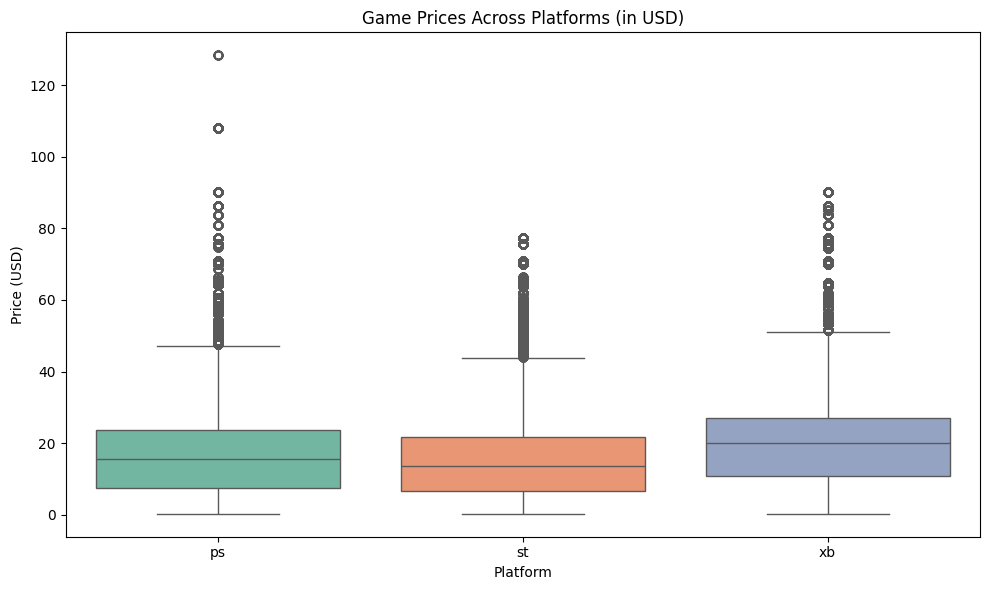

In [75]:
### Boxplot visualizing the distribution of game prices (in USD) across platforms

# Convert prices to USD
exchange_rates = {
    'eur': 1.08, 
    'gbp': 1.29, 
    'jpy': 0.0067,
    'rub': 0.012, 
    'usd': 1.0
}

tidy_game_info['price_usd'] = tidy_game_info.apply(
    lambda row: row['price'] * exchange_rates.get(row['currency'].lower(), 1.0), axis=1
)

# Visualize price distribution across platforms
plt.figure(figsize=(10, 6))
sns.boxplot(x='platform', y='price_usd', hue='platform', data=tidy_game_info, palette='Set2', legend=False)

plt.title("Game Prices Across Platforms (in USD)")
plt.xlabel("Platform")
plt.ylabel("Price (USD)")
plt.tight_layout()
plt.show()

### Number of Achievements Distribution of Shared Games Across Platforms

Interpretation:
- The number of achievements per game typically stays below 50, with a few outliers over 100.
- Games on PlayStation generally feature more achievements than games on other platforms, while games on Steam have a wider range with outliers reaching over 1000.

count    10398.000000
mean        41.527890
std         61.519762
min          0.000000
25%         19.000000
50%         31.000000
75%         50.000000
max       4820.000000
Name: achievements_per_game, dtype: float64


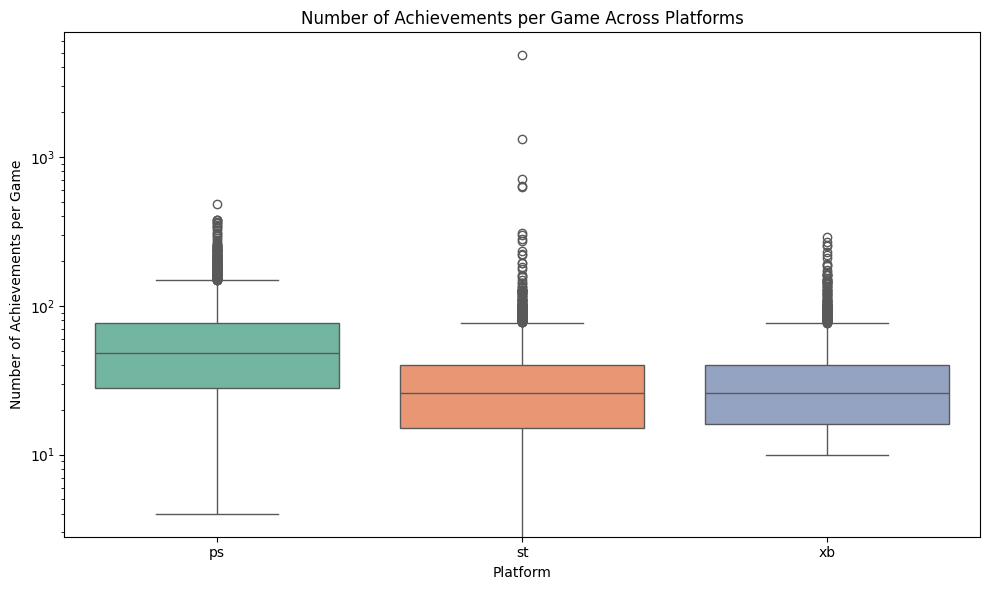

In [76]:
### Boxplot visualizing the distribution of the number of achievements per game across platform

achievements_per_game = tidy_game_info.groupby(["title", "platform"])["achievementid"].nunique().reset_index()
achievements_per_game.rename(columns={"achievementid": "achievements_per_game"}, inplace=True)

print(achievements_per_game['achievements_per_game'].describe())

plt.figure(figsize=(10, 6))
sns.boxplot(x='platform', y='achievements_per_game', hue='platform', data=achievements_per_game, palette='Set2', legend=False)

plt.title("Number of Achievements per Game Across Platforms")
plt.xlabel("Platform")
plt.ylabel("Number of Achievements per Game")
plt.yscale('log')
plt.tight_layout()
plt.show()

### Distribution of Top 10 Popular Genre Tags of Shared Games Across Platforms

Interpretation: 
- The Top 10 most commonly assigned genres for shared games across platforms are Indie, Adventure, Action, RPG, Simulation, Strategy, Platformer, Casual, Turn-Based, and Puzzle.
- Steam has the highest frequency of Top 10 genre tags assigned to shared games compared to PlayStation and Xbox, indicating that a larger proportion of games on Steam might be categorized with certain genres.

platform          ps         st        xb
genres                                   
Indie       7.111988  21.286433  5.377374
Adventure   7.651840  15.989195  9.944078
Action      3.637378  21.155339  7.477222
RPG         7.748229   7.982374  7.204869
Simulation  3.650442   7.894061  4.251958
Strategy    3.224986   6.535450  3.247911
Platformer  7.419870   0.000000  4.897708
Casual      0.308587   9.025932  0.375719
Turn Based  4.603744   0.000000  4.152657
Puzzle      4.182173   0.000000  3.135834


<Figure size 1200x800 with 0 Axes>

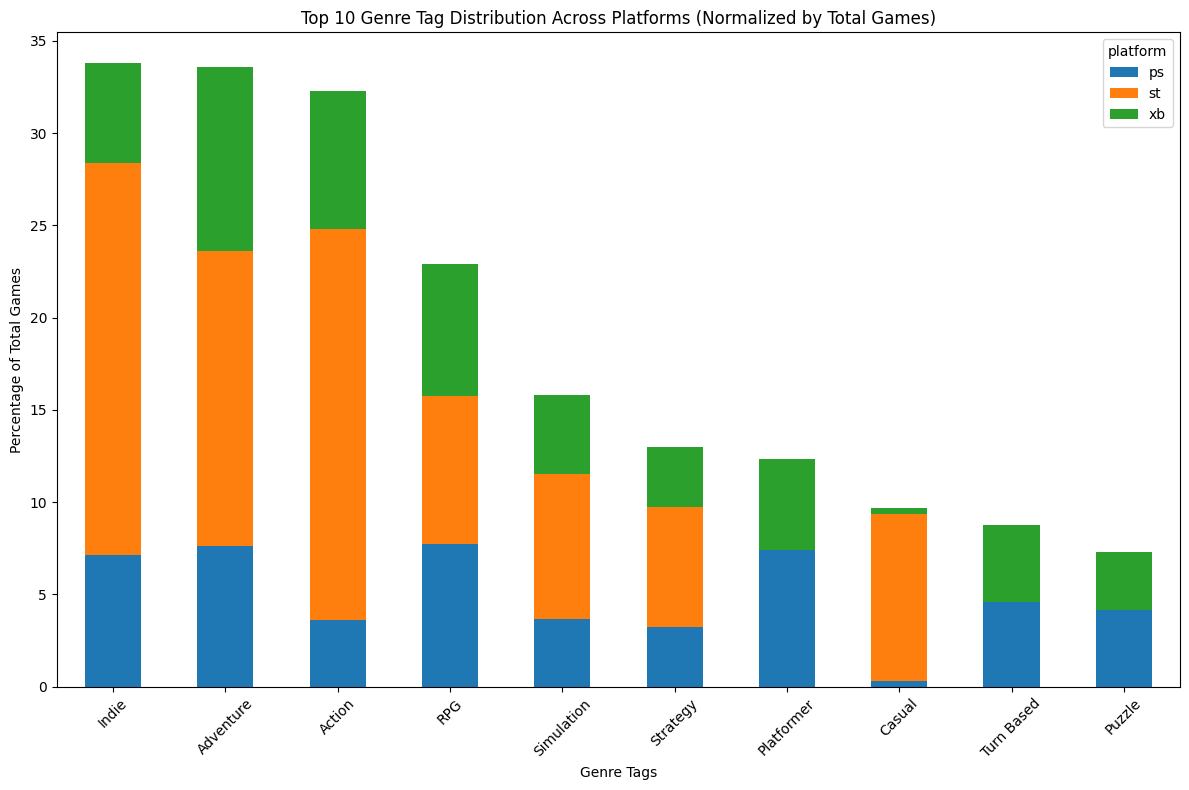

In [77]:
### Stacked barplot visualizing the distribution of the top 10 genre tags across different platforms

# Clean and explode genres into separate rows
tidy_game_info['genres'] = tidy_game_info['genres'].apply(lambda x: x.strip("[]").replace("'", '').split(', ') if isinstance(x, str) else x)
tidy_game_info = tidy_game_info.explode('genres')  

# Replace 'Role Playing' genre with 'RPG' genre
tidy_game_info['genres'] = tidy_game_info['genres'].replace({'Role Playing': 'RPG'})

# Normalize genre counts by the total number of games on each platform
total_games_per_platform = tidy_game_info['platform'].value_counts()
genre_counts_per_platform = tidy_game_info.groupby(['platform', 'genres']).size().reset_index(name='count')
genre_counts_per_platform['percentage'] = genre_counts_per_platform.apply(
    lambda row: row['count'] / total_games_per_platform[row['platform']] * 100, axis=1
)

# Select top 10 genres
top_10_genres = genre_counts_per_platform.groupby('genres')['percentage'].sum().sort_values(ascending=False).head(10).index
top_10_genre_data = genre_counts_per_platform[genre_counts_per_platform['genres'].isin(top_10_genres)]

# Pivot the data to prepare for stacking by platform with genres on the x-axis
top_10_genre_data_pivot = top_10_genre_data.pivot_table(
    index='genres', columns='platform', values='percentage', aggfunc='sum', fill_value=0
)
top_10_genre_data_pivot = top_10_genre_data_pivot.loc[top_10_genres]
print(top_10_genre_data_pivot)


plt.figure(figsize=(12, 8))
top_10_genre_data_pivot.plot(kind='bar', stacked=True, figsize=(12, 8))

plt.title('Top 10 Genre Tag Distribution Across Platforms (Normalized by Total Games)')
plt.xlabel('Genre Tags')
plt.ylabel('Percentage of Total Games')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# SI 618 WN Project Part II

## **[TODO]** Descriptive Statistics
> Provide a comprehensive summary of your combined dataset using descriptive statistics. This should include means, medians, modes, ranges, variance, and standard deviations for the relevant features of your data.  The descriptive statistics should inform your guiding questions that you developed in Part I of the project, rather than merely providing an overview of your data.  Interpret these results to draw preliminary conclusions about the data.


## Inferential statistics
Conduct appropriate _hypothesis tests_ to investigate if there are significant differences or correlations within your data.  This might involve regression analysis, ANOVA, and/or chi-squared tests.
Clearly state your null and alternative hypotheses, choose an appropriate significance level, and discuss your findings. Make sure to justify the choice of your tests.

In [78]:
for col in tidy_game_info.columns:
    unique_values = tidy_game_info[col].nunique()
    total_rows = len(tidy_game_info)
    
    print(f"{col}: {unique_values}/{total_rows} unique values")
    
    if unique_values == total_rows:
        print(f"{col} is a unique identifier\n")

gameid: 14839/3913375 unique values
title: 3466/3913375 unique values
developers: 3427/3913375 unique values
publishers: 2430/3913375 unique values
genres: 112/3913375 unique values
supported_languages: 3071/3913375 unique values
release_date: 2570/3913375 unique values
achievementid: 431807/3913375 unique values
achievement_title: 114017/3913375 unique values
achievement_description: 153785/3913375 unique values
platform: 3/3913375 unique values
currency: 5/3913375 unique values
price: 1580/3913375 unique values
price_usd: 2062/3913375 unique values


In [79]:
tidy_game_info.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3913375 entries, 0 to 2159924
Data columns (total 14 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   gameid                   int64  
 1   title                    object 
 2   developers               object 
 3   publishers               object 
 4   genres                   object 
 5   supported_languages      object 
 6   release_date             object 
 7   achievementid            object 
 8   achievement_title        object 
 9   achievement_description  object 
 10  platform                 object 
 11  currency                 object 
 12  price                    float64
 13  price_usd                float64
dtypes: float64(2), int64(1), object(11)
memory usage: 447.9+ MB


In [80]:
ps_player_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19861683 entries, 0 to 19861682
Data columns (total 10 columns):
 #   Column         Dtype  
---  ------         -----  
 0   playerid       int64  
 1   nickname       object 
 2   country        object 
 3   achievementid  object 
 4   date_acquired  object 
 5   gameid         float64
 6   title          object 
 7   description    object 
 8   rarity         object 
 9   library        object 
dtypes: float64(1), int64(1), object(8)
memory usage: 1.5+ GB


In [81]:
st_player_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11113724 entries, 0 to 11113723
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   playerid       int64  
 1   country        object 
 2   created        object 
 3   achievementid  object 
 4   date_acquired  object 
 5   gameid         float64
 6   title          object 
 7   description    object 
 8   library        object 
dtypes: float64(1), int64(1), object(7)
memory usage: 763.1+ MB


In [82]:
xb_player_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15545366 entries, 0 to 15545365
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   playerid       int64  
 1   nickname       object 
 2   achievementid  object 
 3   date_acquired  object 
 4   gameid         float64
 5   title          object 
 6   description    object 
 7   points         float64
 8   library        object 
dtypes: float64(2), int64(1), object(6)
memory usage: 1.0+ GB


### 1. Are games with more achievements associated with price?
Since we are only testing whether a relationship between number of achievements and price in USD exists, **Pearson’s correlation** is appropriate.
Here are the justifications:
- Both variables are continuous (necessary for Pearson’s correlation).
- We wanted to test for linear associations rather than predictive modeling (which would require regression).
- Significance level evaluation (p-value) helps determine if observed correlations are likely due to chance.

#### Null Hypothesis (H0)
There is no significant correlation between the number of achievements and game price.

#### Alternative Hypothesis (H1)
There is a significant correlation between the number of achievements and game price.


In [83]:
import statsmodels.api as sm

achievement_counts = tidy_game_info.groupby(['gameid', 'platform'])['achievementid'].count().reset_index()
achievement_counts.rename(columns={'achievementid': 'num_achievements'}, inplace=True)

game_price_data = tidy_game_info[['gameid', 'platform', 'price_usd']].drop_duplicates()
df_p_a = pd.merge(achievement_counts, game_price_data, on=['gameid', 'platform'])

In [84]:
achievement_counts

,gameid,platform,num_achievements
0,51,ps,255
1,55,ps,455
2,67,ps,245
3,81,ps,60
4,84,ps,60
...,...,...,...
14847,3135560,st,0
14848,3143880,st,1005
14849,3165620,st,555
14850,3221740,st,210


In [85]:
tidy_game_info[tidy_game_info['gameid']==51].duplicated().sum()

np.int64(0)

In [86]:
df_p_a.dropna(subset=['price_usd', 'num_achievements'], inplace=True)

In [87]:
from scipy.stats import pearsonr

def compute_pearson(df, platform):
    subset = df[df['platform'] == platform].dropna(subset=['num_achievements', 'price_usd'])
    
    r, p_value = pearsonr(subset['num_achievements'], subset['price_usd'])
    return platform, r, p_value

platforms = df_p_a['platform'].unique()
results = [compute_pearson(df_p_a, platform) for platform in platforms]

pearson_results = pd.DataFrame(results, columns=['Platform', 'Correlation (r)', 'p-value'])
pearson_results

,Platform,Correlation (r),p-value
0,ps,0.428426,0.000000e+00
1,xb,0.382704,0.000000e+00
2,st,0.115512,1.609254e-49


In [88]:
def interpret_pearson_results(df):

    interpretations = []
    
    for _, row in df.iterrows():
        platform = row["Platform"]
        r = row["Correlation (r)"]
        p = row["p-value"]
        
        # alpha: significance level
        if p < 0.01:
            significance = "highly significant (p < 0.01)"
        elif p < 0.05:
            significance = "significant (p < 0.05)"
        else:
            significance = "not significant (p >= 0.05)"
        
        # r: strength and direction of correlation
        r_abs = abs(r)
        if r_abs >= 0.7:
            strength = "a strong correlation"
        elif r_abs >= 0.4:
            strength = "a moderate correlation"
        elif r_abs >= 0.2:
            strength = "a weak correlation"
        else:
            strength = "no meaningful correlation"

        if r > 0:
            direction = "positive (more achievements is associated with higher price)"
        elif r < 0:
            direction = "negative (more achievements is associated with lower price)"
        else:
            direction = "no correlation at all"

        interpretation = f"On {platform} platform, there is {strength} ({direction}), and the result is {significance} (r = {r:.2f}, p = {p:.3f}).\n"
        interpretations.append(interpretation)
    
    return "\n".join(interpretations)

interpretation_text = interpret_pearson_results(pearson_results)
print(interpretation_text)

On ps platform, there is a moderate correlation (positive (more achievements is associated with higher price)), and the result is highly significant (p < 0.01) (r = 0.43, p = 0.000).

On xb platform, there is a weak correlation (positive (more achievements is associated with higher price)), and the result is highly significant (p < 0.01) (r = 0.38, p = 0.000).

On st platform, there is no meaningful correlation (positive (more achievements is associated with higher price)), and the result is highly significant (p < 0.01) (r = 0.12, p = 0.000).



#### Interpretation
- PlayStation Platform: Moderate positive correlation (r = 0.43), highly significant (p < 0.01) → Reject H_0  → More achievements are moderately associated with higher price.
- Xbox Platform: Weak positive correlation (r = 0.38), highly significant (p < 0.01) → Reject H_0  → More achievements are weakly associated with higher price.
- Steam Platform: No meaningful correlation (r = 0.12), highly significant (p < 0.01) → Reject H_0  → Although significant, the correlation is too weak to suggest a strong association.

On PlayStation and Xbox, a higher number of achievements tends to be associated with higher prices, though the relationship is stronger on PS. On Steam, while significant, the association is too weak to be practically meaningful.

### 2. PlayStation and Steam: Do players from different countries tend to complete achievements faster?
#### Test used: One-Way ANOVA
* y: achievement completion time (time_to_achievement = date_acquired - release_date).
* X: country (in merged_player_info).
* Condition: ANOVA assumes normally distributed residuals and equal variances. If these assumptions don’t hold, we may use a Kruskal-Wallis test (non-parametric alternative).

#### Null Hypothesis (H0)
There is no significant difference in achievement completion time among players from different countries.

#### Alternative Hypothesis (HA)
At least one country's players complete achievements at a significantly different speed compared to others.

#### Necessary merging for player-focus info

In [119]:
# standardizing data
ps_player_info["player_platform"] = "ps"
ps_player_info.rename(columns={"title": "achievement_title"}, inplace=True)
ps_player_info.drop(columns=["rarity", "nickname", "library"], inplace=True)

In [128]:
ps_player_info.sample(5)

,playerid,country,player_platform,achievementid,date_acquired,gameid,achievement_title,description
16141263,1646679,Italy,ps,67_1735,2013-01-22 22:11:50,67.0,Survivor,Complete the game on any difficulty setting
14041198,403577,United Kingdom,ps,440433_3986491,2022-01-04 01:49:52,440433.0,More Than Lint,Enter a Hidden Pocket Dimension
13039924,2086156,Brazil,ps,385455_3582691,2023-10-30 04:31:55,385455.0,I Want Ten People,Collected 10 or more playable characters
9450717,292969,Canada,ps,19058_182128,2019-02-24 00:45:53,19058.0,Drunk Drawer,Complete the optional graffiti #9 in Episode 3...
11049407,2711470,"Taiwan, Province of China",ps,14278_149098,2022-08-14 12:31:34,14278.0,White Eternity,ムービー「White Eternity」を見た。


In [121]:
st_player_info["player_platform"] = "st"
st_player_info.rename(columns={"title": "achievement_title"}, inplace=True)
st_player_info.drop(columns=["created", "library"], inplace=True)

In [127]:
st_player_info.sample(5)

,playerid,country,player_platform,achievementid,date_acquired,gameid,achievement_title,description
1124196,76561198298591193,Germany,st,710120_NEW_ACHIEVEMENT_150_14,2018-03-28 14:53:18,710120.0,Super Trivia Champion,Super Trivia Champion
843421,76561198298591193,Germany,st,567290_tSmall,2020-05-21 22:18:24,567290.0,T,Score 10 points with the letter T!
5685798,76561198246511970,Thailand,st,NaN,NaN,NaN,NaN,NaN
2089734,76561198307860947,NaN,st,687490_NEW_ACHIEVEMENT_57_7,2021-11-25 06:16:46,687490.0,Super Trivia Champion \t,Super Trivia Champion \t
252780,76561197987596512,Brazil,st,693880_NEW_ACHIEVEMENT_182_20,2018-04-16 07:57:05,693880.0,Super Trivia Champion,Super Trivia Champion


In [123]:
xb_player_info["player_platform"] = "xb"
xb_player_info.rename(columns={"title": "achievement_title"}, inplace=True)
xb_player_info.drop(columns=["points", "nickname", "library"], inplace=True)

xb_player_info["country"] = 'Unknown'

In [129]:
xb_player_info.sample(5)

,playerid,country,player_platform,achievementid,date_acquired,gameid,achievement_title,description
2409881,848604,Unknown,xb,2772_317847,2011-12-20 09:01:12,2772.0,Medicine is the Best Medicine,Picked up a health pack when a hero was about ...
7255268,840412,Unknown,xb,1529_276510,2008-12-29 19:34:30,1529.0,Caught on Camera,Sent a video replay to a Friend over Xbox LIVE...
12606593,797003,Unknown,xb,1612_279394,2010-01-08 02:24:32,1612.0,Demolition Derby,You destroyed 50 vehicles.
8346213,2133096,Unknown,xb,5720_340760,2014-08-01 03:31:06,5720.0,Specialist,Maxed out a single attribute.
3821381,4311264,Unknown,xb,560245_4686264,2023-09-14 22:18:27,560245.0,Heavy Metal Is the Law,Completed a Torment


In [125]:
for df, name in zip([ps_player_info, st_player_info, xb_player_info], ["PS", "ST", "XB"]):
    duplicates = df.duplicated(subset=["playerid", "gameid", "achievementid"], keep=False).sum()
    print(f"{name}: {duplicates} potential duplicate entries on (playerid, gameid, achievementid).")

PS: 0 potential duplicate entries on (playerid, gameid, achievementid).
ST: 0 potential duplicate entries on (playerid, gameid, achievementid).
XB: 0 potential duplicate entries on (playerid, gameid, achievementid).


In [126]:
columns_order = [
    "playerid", "country", "player_platform", "achievementid",
    "date_acquired", "gameid", "achievement_title", "description"
]

ps_player_info = ps_player_info[columns_order]
st_player_info = st_player_info[columns_order]
xb_player_info = xb_player_info[columns_order]

In [130]:
merged_player_info = pd.concat([ps_player_info, st_player_info, xb_player_info], ignore_index=True)

In [131]:
merged_player_info.sample(5)

,playerid,country,player_platform,achievementid,date_acquired,gameid,achievement_title,description
24550098,76561198405866201,NaN,st,806140_NEW_ACHIEVEMENT_39_26,2018-07-04 10:39:51,806140.0,Elephants,part 6
32740329,847759,Unknown,xb,2539_309031,2019-08-08 04:51:55,2539.0,World's Best Dad,Said things to Jess that no parent should ever...
37493036,843860,Unknown,xb,15738_385855,2021-12-20 20:29:05,15738.0,Lovely Bunch of Coconuts,Collected 8 Skulls.
13356691,1134361,Canada,ps,13504_143083,2017-06-06 20:16:37,13504.0,Dragon Slayer,Fin Fang Foom was defeated.
44741463,762042,Unknown,xb,6577_345128,2016-11-18 21:02:01,6577.0,Tightening the Noose,Stopped Abigail and saved Rex and Joy


In [132]:
merged_player_info['date_acquired'] = merged_player_info['date_acquired'].str[:10]

In [133]:
merged_player_info.sample(5)

,playerid,country,player_platform,achievementid,date_acquired,gameid,achievement_title,description
20517204,76561198179588026,Germany,st,865360_COMPLETE_NUMBER_LINK_TOWER,2021-03-21,865360.0,The Tower,NaN
7726227,342191,United States,ps,8161_99879,2016-07-25,8161.0,H-E...,Complete all open world gameplay in two distri...
933723,318566,Japan,ps,10600_124388,2016-09-06,10600.0,Fanboi,Put Ken's or Morohoshi's car in your garage
3246168,4363811,United Kingdom,ps,7779_95658,2014-11-21,7779.0,The Big One!,This ain't no dream no more.
392272,3065998,United Arab Emirates,ps,547651_4580611,2022-12-15,547651.0,Travel 20000 m in total.,Travel 20000 m in total.


In [95]:
print(f"Merged dataset shape: {merged_player_info.shape}")
print(f"Merged dataset duplicates: {merged_player_info.duplicated().sum()}")
print(merged_player_info.info())

Merged dataset shape: (46520773, 8)
Merged dataset duplicates: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46520773 entries, 0 to 46520772
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   playerid           int64  
 1   country            object 
 2   player_platform    object 
 3   achievementid      object 
 4   date_acquired      object 
 5   gameid             float64
 6   achievement_title  object 
 7   description        object 
dtypes: float64(1), int64(1), object(6)
memory usage: 2.8+ GB
None


#### ANOVA

In [ ]:
merged_player_info.sample(5)

,playerid,country,player_platform,achievementid,date_acquired,gameid,achievement_title,description
22978452,76561198331654944,NaN,st,508900_2276,2022-09-13,508900.0,🚀!,Pass the level 🚀!
34156302,2121813,Unknown,xb,18300_394912,2024-09-16,18300.0,Mic Drop,Win your first argument.
36679576,845144,Unknown,xb,519712_4454668,2024-06-12,519712.0,Next Stop: Escape Academy,"Escape ""Introductions."""
40366899,831433,Unknown,xb,1236_292075,2009-12-05,1236.0,Challenging Schedule,Complete a Manager Mode Season without simming...
46044829,1936663,Unknown,xb,399354_3655088,2022-10-21,399354.0,Rodent's Bane,Defeat the rats in the cellar


In [ ]:
import copy
merged_player_info_cp = merged_player_info.copy()
tidy_game_info_cp = tidy_game_info.copy()

mp_filtered = merged_player_info_cp[['playerid', 'country', 'date_acquired', 'gameid', 'player_platform']]
tg_filtered = tidy_game_info[['gameid', 'release_date']]

In [150]:
mp_filtered['date_acquired'].sample(10)

30298029    2015-01-27
4567205     2011-07-07
24502669    2017-12-06
9177773     2022-01-18
4433743     2019-07-01
3500347     2011-10-12
6170693     2023-10-25
7226476     2023-08-30
26942951    2020-08-28
28122684    2022-12-17
Name: date_acquired, dtype: object

In [151]:
mp_filtered = mp_filtered[mp_filtered['player_platform'].isin(['ps', 'st'])]
mp_filtered['date_acquired'] = pd.to_datetime(mp_filtered['date_acquired'], errors='coerce')
tg_filtered['release_date'] = pd.to_datetime(tg_filtered['release_date'], errors='coerce')

/var/folders/vr/syshz9v92js62ld8ch0rw37r0000gn/T/ipykernel_98820/94971596.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tg_filtered['release_date'] = pd.to_datetime(tg_filtered['release_date'], errors='coerce')


In [155]:
game_release_dict = tg_filtered.set_index('gameid')['release_date'].to_dict()
mp_filtered['release_date'] = mp_filtered['gameid'].map(game_release_dict)

mp_filtered['time_to_achievement'] = (mp_filtered['date_acquired'] - mp_filtered['release_date']).dt.days

# remove invalid/negative completion times
mp_filtered = mp_filtered[(mp_filtered['time_to_achievement'] >= 0) & (mp_filtered['time_to_achievement'].notna())]

# filter countries with at least 100 players for meaningful analysis
country_counts = mp_filtered['country'].value_counts()
mp_filtered = mp_filtered[mp_filtered['country'].isin(country_counts[country_counts >= 100].index)]

In [ ]:
from scipy import stats

# check for normality
# sample 5000 rows for normality test (Shapiro-Wilk does not work well on very large data)
sample_df = mp_filtered.sample(n=min(5000, len(mp_filtered)), random_state=42)

stat, p = stats.shapiro(sample_df['time_to_achievement'])
print(f"Shapiro-Wilk Test: p-value = {p:.4f}")

if p < 0.05:
    print("Time-to-achievement is NOT normally distributed.")
else:
    print("Time-to-achievement appears normally distributed.")


Shapiro-Wilk Test: p-value = 0.0000
Time-to-achievement is NOT normally distributed.


In [159]:
# Levene’s test for equal variances across countries
stat, p = stats.levene(*[mp_filtered[mp_filtered['country'] == c]['time_to_achievement'] for c in mp_filtered['country'].unique()])
print(f"Levene’s Test: p-value = {p:.4f}")

if p < 0.05:
    print("Variances are NOT equal (consider Welch's ANOVA).")
else:
    print("Variances are approximately equal (proceed with standard ANOVA).")


Levene’s Test: p-value = 0.0000
Variances are NOT equal (consider Welch’s ANOVA).


#### Since both assumptions for ANOVA are violated (not normally distributed nor equal variance), we choose to run **Kruskal-Wallis (one-way ANOVA on ranks)** instead.

In [160]:
kruskal_result = stats.kruskal(*[mp_filtered[mp_filtered['country'] == c]['time_to_achievement'] for c in mp_filtered['country'].unique()])
print(f"Kruskal-Wallis Test: H-statistic = {kruskal_result.statistic:.4f}, p-value = {kruskal_result.pvalue:.4f}")

if kruskal_result.pvalue < 0.05:
    print("Reject H0: There is a significant difference in achievement completion time across countries (non-parametric).")
else:
    print("Fail to reject H0: No significant difference in completion time across countries.")

Kruskal-Wallis Test: H-statistic = 331601.9087, p-value = 0.0000
Reject H0: There is a significant difference in achievement completion time across countries (non-parametric).


### Interpretation of Kruskal-Wallis (one-way ANOVA on ranks) results

We conducted a **Kruskal-Wallis test**, a non-parametric alternative to ANOVA, due to violations of normality and/or equal variance assumptions.  

- H-statistic = 331601.9087, **p-value = 0.0000**  
- Since **p < 0.05**, we **reject the null hypothesis (H_0)**.  
- This result indicates a **statistically significant difference** in **achievement completion times across countries** on **PlayStation and Steam** platforms.  

### 3. [relate to graphical analysis #4] Do games with more supported languages attract more players?
We will conduct a **linear regression analysis** to determine whether the number of supported languages influences the number of players who purchased a game.
* The dependent variable (num_players_purchased) is continuous.
* The independent variable (num_supported_languages) is continuous.
* OLS regression helps quantify the strength and significance of the relationship.

#### Null Hypothesis:
The number of supported languages in a game does not significantly predict the number of players who purchased it.

#### Alternative Hypothesis:
The number of supported languages in a game significantly influences the number of players who purchased it.

In [177]:
lst = tidy_game_info_cp['supported_languages'].sample()
lst.iloc[0]

"['English', 'French', 'Italian', 'German', 'Spanish - Spain', 'Arabic', 'Dutch', 'Japanese', 'Korean', 'Polish', 'Portuguese - Portugal', 'Portuguese - Brazil', 'Russian', 'Simplified Chinese', 'Spanish - Latin America', 'Traditional Chinese', 'Turkish']"

In [178]:
import ast

game_data = tidy_game_info[['gameid', 'supported_languages']].copy()

# convert string-formatted lists to actual lists and count the number of languages
game_data['num_languages'] = game_data['supported_languages'].apply(lambda x: len(ast.literal_eval(x)) if isinstance(x, str) else 0)

# keep only numeric values
game_data.drop(columns=['supported_languages'], inplace=True)

In [185]:
game_data.sample(10)

,gameid,num_languages
480007,465634,4
1457877,527795,0
1208742,446493,0
1813044,168465,13
181681,443242,11
412771,529547,0
285464,414760,1
746180,1918040,14
2012421,427510,3
747582,1584450,2


In [186]:
# unique players per game
player_counts = merged_player_info_cp.groupby('gameid')['playerid'].nunique().reset_index()
player_counts.rename(columns={'playerid': 'num_players'}, inplace=True)

df_regression = game_data.merge(player_counts, on='gameid', how='inner')

In [187]:
df_regression.sample(5)

,gameid,num_languages,num_players
1824242,657224,8,1
1494017,444930,1,9
1032390,219150,7,351
868682,444930,1,9
1603144,359900,9,7


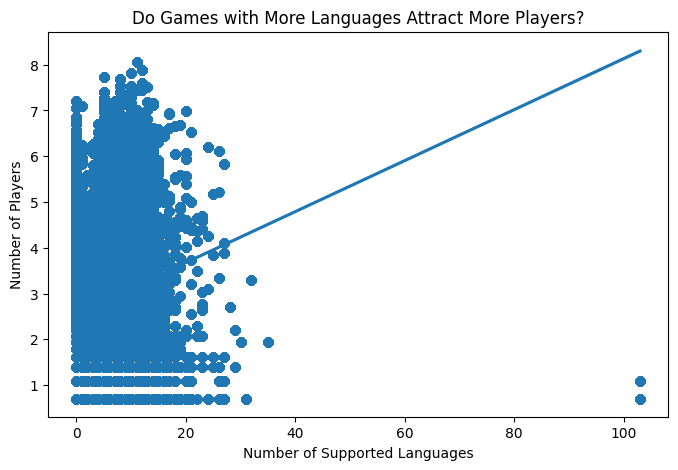

In [193]:
df_regression['log_num_players'] = np.log1p(df_regression['num_players'])


plt.figure(figsize=(8,5))
sns.regplot(x=df_regression['num_languages'], y=df_regression['log_num_players'])
plt.xlabel("Number of Supported Languages")
plt.ylabel("Number of Players (log transformed)")
plt.title("Do Games with More Languages Attract More Players?")
plt.show()

#### Since the scatterplot does not suggest a strong linear relationship between the number of supported languages and the number of players, we decided to switch to bin the number of supported languages and evaluate the binned variable and the number of players again.

/var/folders/vr/syshz9v92js62ld8ch0rw37r0000gn/T/ipykernel_98820/145610165.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_regression.groupby('language_bins')['num_players'].mean().plot(kind="bar")


<Axes: xlabel='language_bins'>

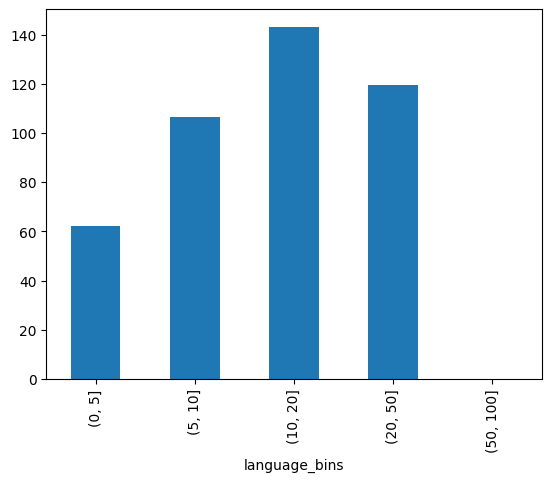

In [191]:
df_regression['language_bins'] = pd.cut(df_regression['num_languages'], bins=[0, 5, 10, 20, 50, 100])
df_regression.groupby('language_bins')['num_players'].mean().plot(kind="bar")

#### This visualization leads us to use ANOVA to test the statistical significance between bins of supported languages.

In [192]:
from scipy.stats import f_oneway

# only non-empty bins are included
groups = [df_regression[df_regression['language_bins'] == b]['num_players'].dropna() 
          for b in df_regression['language_bins'].unique() 
          if len(df_regression[df_regression['language_bins'] == b]) > 0]

if len(groups) > 1:  # at least two groups
    f_stat, p_val = f_oneway(*groups)
    print(f"ANOVA Test: F = {f_stat:.4f}, p = {p_val:.4f}")
else:
    print("ANOVA cannot be performed: Not enough non-empty groups.")


ANOVA Test: F = 10413.1380, p = 0.0000


### Interpretation of ANOVA Results: Number of Supported Languages vs. Player Count

- F-statistic = 10413.1380, **p-value = 0.0000**  
- Since **p < 0.05**, we **reject the null hypothesis (H_0)**.  
- This indicates a **statistically significant difference** in the **number of players across language support bins**.  

### 4. Do expensive vs. cheap games have different likelihoods of being cross-platform?
#### Variables and groups
* price category (high/low) vs. single vs. multi-platform.

#### Test Used: Chi-Square Test of Independence
* Both variables are categorical, and we want to test for association.

#### Null Hypothesis
There is no significant association between a game’s price category (high/low) and whether it is single-platform or multi-platform.

#### Alternative Hypothesis
There is a significant association between a game’s price category and its likelihood of being cross-platform.

In [208]:
tidy_game_info_cp.columns

Index(['gameid', 'title', 'developers', 'publishers', 'genres',
       'supported_languages', 'release_date', 'achievementid',
       'achievement_title', 'achievement_description', 'platform', 'currency',
       'price', 'price_usd'],
      dtype='object')

In [236]:
from scipy.stats import chi2_contingency

df_price_platform = tidy_game_info_cp[['title', 'price_usd', 'platform']].dropna(subset=['price_usd', 'platform']).drop_duplicates()

# price categories based on median price
median_price = df_price_platform['price_usd'].median()
df_price_platform['price_category'] = np.where(df_price_platform['price_usd'] <= median_price, 'Cheap', 'Expensive')

In [237]:
df_price_platform.duplicated().sum()

np.int64(0)

In [241]:
# classify: single-platform or cross-platform
platform_counts = df_price_platform.groupby('title')['platform'].nunique().reset_index()
platform_counts.rename(columns={'platform': 'num_platforms'}, inplace=True)

df_price_platform = df_price_platform.merge(platform_counts, on='title', how='left')

df_price_platform['platform_type'] = np.where(df_price_platform['num_platforms'] > 1, 'Multi-Platform', 'Single-Platform')

print(df_price_platform['num_platforms'].value_counts())


num_platforms
3    39144
2     1491
1      232
Name: count, dtype: int64


In [244]:
contingency_table = pd.crosstab(df_price_platform['price_category'], df_price_platform['platform_type'])

chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-Square Test: χ² = {chi2_stat:.4f}, p-value = {p_val:.4f}")

if p_val < 0.05:
    print("Reject H0: There is a significant association between game price category and platform availability.")
else:
    print("Fail to reject H0: No significant association between game price category and platform availability.")

Chi-Square Test: χ² = 3.9091, p-value = 0.0480
Reject H0: There is a significant association between game price category and platform availability.


### Interpretation of Chi-Square Test
- χ² = 3.9091, **p = 0.0480**  
- Since **p < 0.05**, we **reject the null hypothesis (\(H_0\))**.  
- This indicates a **statistically significant association** between a game’s price category (cheap vs. expensive) and its likelihood of being cross-platform.

## Graphical analysis
Create various types of plots to visualize relationships within your data. Use histograms, bar charts, scatter plots, box plots, and any other suitable graphical representations you've learned.
Be sure to use appropriate titles, labels, and legends to make your plots readable and informative.
Interpret the graphical representations to uncover patterns, trends, and outliers.

### 1. **Game dedication** across countries: Which countries have the most dedicated gamers?
- measured by achievements earned per player
- visualization type: heatmap (?) showing achievements per player by country.


### 1.1 Profile analysis of the most dedicated gamers per country

### 2. How do the top 10 most **expensive** games compare in terms of player purchases and achievements?
- Another way to put: are expensive games are widely played?
- visualization type: scatterplot of price vs. player count, colored by genre.

### 3. How do achievement completion rates compare across platforms for the top 10 most **purchased** cross-platform games?
- visualization type: stacked bar chart for the distribution of achievement completion rates per game, grouped by platform.

### 4. How does the number of **supported languages** vary across different genres, and does that affect purchases?
- Another way to put: Do certain genres prioritize localization more? Does that lead to more sales?
- visualization type: boxplot for the number of supported languages grouped by genre, with another layer for player counts.

### 5. Do more **engaging** cross-platform games have faster or slower completion rates (player retention)?
- helpful - number of users who found the review helpful
- funny - number of users who found the review funny
- awards - number of awards given to the review